# Analysis of my local benchmarker

In [1]:
import ast
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import json

def parse_ingest(time_string: str) -> list[list[timedelta]]:
    """
    input are concatinated list, one list for each load generator
    """
    # Split the string into its lists
    time_strings = time_string.split('][')
    
    all_time_deltas = []

    for ts in time_strings:
        # fix lists after split
        if not ts.startswith('['):
            ts = '[' + ts
        if not ts.endswith(']'):
            ts = ts + ']'

        # Evaluate the string to a list
        time_list = ast.literal_eval(ts)

        # convert into timedelta
        time_deltas = []
        for t in time_list:
            h, m, s = t.split(':')
            s, ms = s.split('.')
            time_deltas.append(timedelta(hours=int(h), minutes=int(m), seconds=int(s), microseconds=int(ms)))

        all_time_deltas.append(time_deltas)

    return all_time_deltas

INGEST_FILE = "./results_1705359973.txt"

with open(INGEST_FILE, "r") as fp:
    ingest_str = fp.read()

ingest_data = parse_ingest(ingest_str)

In [2]:
def plot_total_ingestion_time_throughput(ingestion_times, total_documents):
    total_time = sum((sum(inner_list, timedelta()) for inner_list in ingestion_times), timedelta())
    total_seconds = total_time.total_seconds()

    throughput = total_documents / total_seconds

    print(f"Total seconds: {total_seconds}")
    print(f"Throughput (docs/sec): {throughput}")
    return total_seconds, throughput

plot_total_ingestion_time_throughput(ingest_data, 165346692)

Total seconds: 8456.721415
Throughput (docs/sec): 19552.10345545006


(8456.721415, 19552.10345545006)

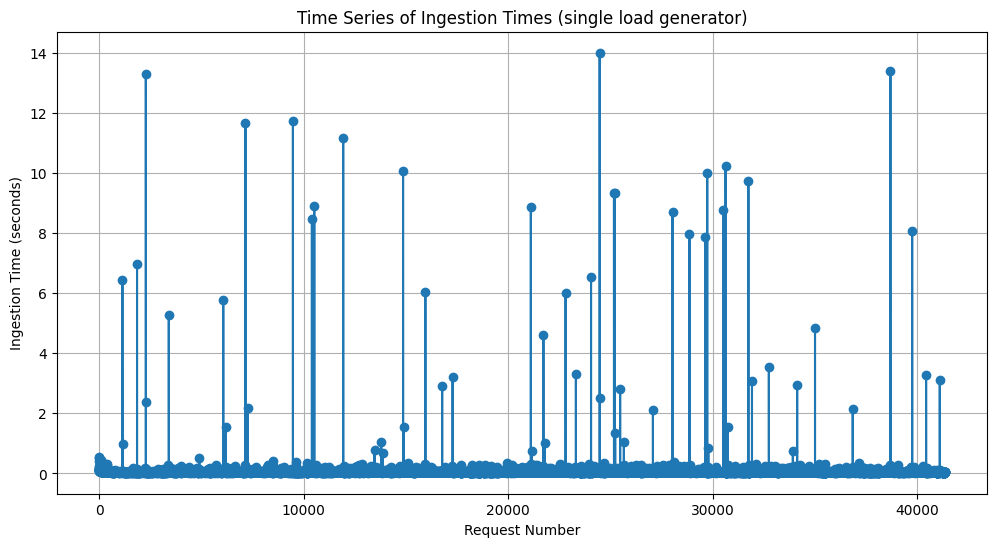

In [3]:
import matplotlib.pyplot as plt
from datetime import timedelta

def plot_time_series(ingestion_times):
    seconds = [td.total_seconds() for td in ingestion_times]

    request_numbers = list(range(1, len(seconds) + 1))

    plt.figure(figsize=(12, 6))
    plt.plot(request_numbers, seconds, marker='o', linestyle='-')
    plt.title('Time Series of Ingestion Times (single load generator)')
    plt.xlabel('Request Number')
    plt.ylabel('Ingestion Time (seconds)')
    plt.grid(True)

    plt.show()

plot_time_series(ingest_data[0])

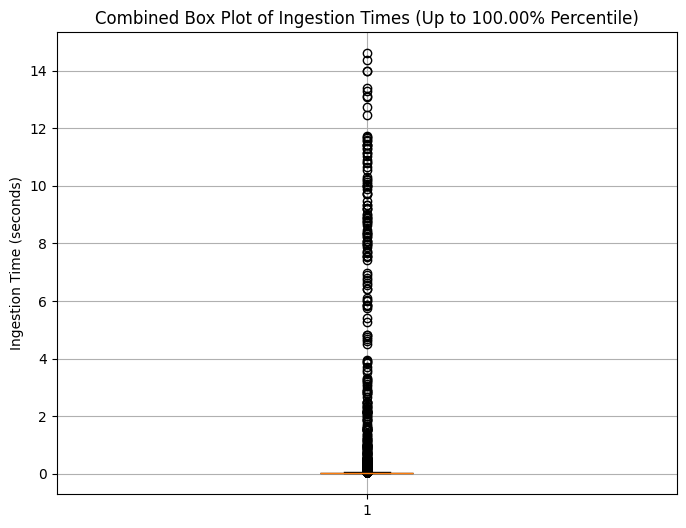

In [4]:
def plot_combined_boxplot(ingestion_times, percentile_cutoff=1.0):
    flat_list = [td.total_seconds() for sublist in ingestion_times for td in sublist]

    cutoff_value = np.percentile(flat_list, percentile_cutoff * 100)

    filtered_list = [value for value in flat_list if value <= cutoff_value]

    plt.figure(figsize=(8, 6))
    plt.boxplot(filtered_list, vert=True, patch_artist=True)
    plt.title(f'Combined Box Plot of Ingestion Times (Up to {percentile_cutoff:.2%} Percentile)')
    plt.ylabel('Ingestion Time (seconds)')
    plt.grid(True)

    plt.show()

plot_combined_boxplot(ingest_data, percentile_cutoff=1)

In [5]:
def calculate_statistics(timedelta_list):
    seconds_list = [td.total_seconds() for td in timedelta_list]

    mean = np.mean(seconds_list)
    median = np.median(seconds_list)
    q75 = np.percentile(seconds_list, 75)
    q90 = np.percentile(seconds_list, 90)
    q99 = np.percentile(seconds_list, 99)
    q999 = np.percentile(seconds_list, 99.9)
    q9999 = np.percentile(seconds_list, 99.99)

    return {
        "mean": mean,
        "median": median,
        "75th percentile": q75,
        "90th percentile": q90,
        "99th percentile": q99,
        "99.9th percentile": q999,
        "99.99th percentile": q9999
    }

statistics = calculate_statistics(ingest_data[0])
print(f"Mean: {statistics['mean']}")
print(f"Median: {statistics['median']}")
print(f"75th Percentile: {statistics['75th percentile']}")
print(f"90th Percentile: {statistics['90th percentile']}")
print(f"99th Percentile: {statistics['99th percentile']}")
print(f"99.9th Percentile: {statistics['99.9th percentile']}")
print(f"99.99th Percentile: {statistics['99.99th percentile']}")

Mean: 0.0524815438469168
Median: 0.04262
75th Percentile: 0.048744
90th Percentile: 0.054347
99th Percentile: 0.1296533199999999
99.9th Percentile: 2.1216848960001444
99.99th Percentile: 11.592226355199482


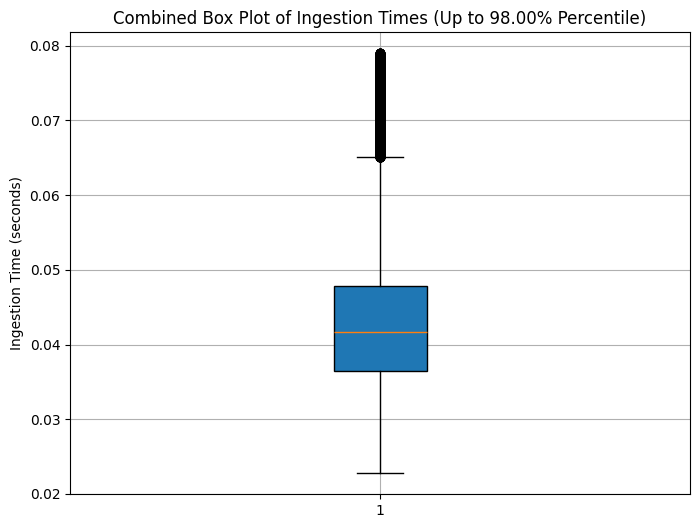

In [6]:
plot_combined_boxplot(ingest_data, percentile_cutoff=0.98)

## Query Benchmark Analysis

In [7]:
QUERY_FILE = "./res.json"

with open(QUERY_FILE, "r") as fp:
    query_data = json.load(fp)
assert len(query_data) == 18

# MATCH_ALL_10: Benchmark data for simple "match_all" query without size limitation (defaults to 10 documents).
# MATCH_ALL_100: Benchmark data for "match_all" query with a size limit of 100 documents.
# MATCH_ALL_1000: Benchmark data for "match_all" query with a size limit of 1000 documents.
# MATCH_ALL_10000: Benchmark data for "match_all" query with a size limit of 10000 documents.
# RANGE_10: Benchmark data for "range" query on "total_amount" field with no specified size limit (defaults to 10 documents).
# RANGE_100: Benchmark data for "range" query on "total_amount" field, size limit of 100 documents.
# RANGE_1000: Benchmark data for "range" query on "total_amount" field, size limit of 1000 documents.
# RANGE_10000: Benchmark data for "range" query on "total_amount" field, size limit of 10000 documents.
# RANGE_MATCH_ALL_MIXED: Benchmark data for mixed queries, both "range" on "total_amount" and "match_all" running alternatively, each with size limit of 1000.
# MATCH_ALL_SLEEP_0_02_SECS: Benchmark data for "match_all" query with a size limit of 1000 and a sleep interval of 0.02 seconds between requests.
# MATCH_ALL_SLEEP_0_05_SECS: Similar to the above but with a sleep interval of 0.05 seconds.
# MATCH_ALL_SLEEP_0_1_SECS: Similar to the above but with a sleep interval of 0.1 seconds.
# MATCH_ALL_SLEEP_0_2_SECS: Similar to the above but with a sleep interval of 0.2 seconds.
# MATCH_ALL_SLEEP_0_5_SECS: Similar to the above but with a sleep interval of 0.5 seconds.
# MATCH_ALL_SLEEP_1_SEC: Similar to the above but with a sleep interval of 1 second.
# AGGS_HIST: Benchmark data for an aggregation query creating a histogram on "trip_distance" and calculating stats for "total_amount".
# AGGS_HIST_DATETIME_BUCKETS: Benchmark data for a range query with aggregation over "dropoff_datetime" using auto date histogram with 20 buckets.
# AGGS_HIST_DATETIME_BY_DAY: Benchmark data for a range query with aggregation over "dropoff_datetime" using a date histogram with daily intervals.



# match all scaleup with return size
MATCH_ALL_10 = query_data[0]
MATCH_ALL_100 = query_data[1]
MATCH_ALL_1000 = query_data[2]
MATCH_ALL_10000 = query_data[3]

# range scaleup with return size
RANGE_10 = query_data[4]
RANGE_100 = query_data[5]
RANGE_1000 = query_data[6]
RANGE_10000 = query_data[7]

# mix up match all and range
RANGE_MATCH_ALL_MIXED = query_data[8]

# decrease/increase sleep time between requests
MATCH_ALL_SLEEP_0_02_SECS = query_data[9]
MATCH_ALL_SLEEP_0_05_SECS = query_data[10]
MATCH_ALL_SLEEP_0_1_SECS = query_data[11]
MATCH_ALL_SLEEP_0_2_SECS = query_data[12]
MATCH_ALL_SLEEP_0_5_SECS = query_data[13]
MATCH_ALL_SLEEP_1_SEC = query_data[14]

# Aggregations
AGGS_HIST = query_data[15]
AGGS_HIST_DATETIME_BUCKETS = query_data[16]
AGGS_HIST_DATETIME_BY_DAY = query_data[17]

In [8]:
from dataclasses import dataclass, field
from typing import List, Dict, Optional, Union

@dataclass
class SuccessResponse:
    latency: float
    docs: int

@dataclass
class ErrorResponse:
    error_code: int

Response = Union[SuccessResponse, ErrorResponse]

@dataclass
class QueryResult:
    body: Dict
    # outer list: each load generator
    responses: List[List[Response]]

@dataclass
class BenchmarkStep:
    search_results: List[QueryResult]
    warmup_time_secs: Optional[int] = None
    execution_time_secs: Optional[int] = None
    sleep_between_requests_secs: Optional[float] = None

def parse_json_to_dataclasses(data) -> BenchmarkStep:
    search_results = []
    for result in data['search_results']:
        responses = []
        for load_gen_responses in result['responses']:
            parsed_responses = [SuccessResponse(**response) if 'latency' in response else ErrorResponse(**response) for response in load_gen_responses]
            responses.append(parsed_responses)
        search_results.append(QueryResult(body=result['query']['body'], responses=responses))

    return BenchmarkStep(
        search_results=search_results,
        warmup_time_secs=data.get('warmup_time_secs'),
        execution_time_secs=data.get('execution_time_secs'),
        sleep_between_requests_secs=data.get('sleep_between_requests_secs')
    )

MATCH_ALL_10 = parse_json_to_dataclasses(MATCH_ALL_10)
MATCH_ALL_100 = parse_json_to_dataclasses(MATCH_ALL_100)
MATCH_ALL_1000 = parse_json_to_dataclasses(MATCH_ALL_1000)
MATCH_ALL_10000 = parse_json_to_dataclasses(MATCH_ALL_10000)

RANGE_10 = parse_json_to_dataclasses(RANGE_10)
RANGE_100 = parse_json_to_dataclasses(RANGE_100)
RANGE_1000 = parse_json_to_dataclasses(RANGE_1000)
RANGE_10000 = parse_json_to_dataclasses(RANGE_10000)

RANGE_MATCH_ALL_MIXED = parse_json_to_dataclasses(RANGE_MATCH_ALL_MIXED)

MATCH_ALL_SLEEP_0_02_SECS = parse_json_to_dataclasses(MATCH_ALL_SLEEP_0_02_SECS)
MATCH_ALL_SLEEP_0_05_SECS = parse_json_to_dataclasses(MATCH_ALL_SLEEP_0_05_SECS)
MATCH_ALL_SLEEP_0_1_SECS = parse_json_to_dataclasses(MATCH_ALL_SLEEP_0_1_SECS)
MATCH_ALL_SLEEP_0_2_SECS = parse_json_to_dataclasses(MATCH_ALL_SLEEP_0_2_SECS)
MATCH_ALL_SLEEP_0_5_SECS = parse_json_to_dataclasses(MATCH_ALL_SLEEP_0_5_SECS)
MATCH_ALL_SLEEP_1_SEC = parse_json_to_dataclasses(MATCH_ALL_SLEEP_1_SEC)

AGGS_HIST = parse_json_to_dataclasses(AGGS_HIST)
AGGS_HIST_DATETIME_BUCKETS = parse_json_to_dataclasses(AGGS_HIST_DATETIME_BUCKETS)
AGGS_HIST_DATETIME_BY_DAY = parse_json_to_dataclasses(AGGS_HIST_DATETIME_BY_DAY)

In [9]:
def calculate_error_responses(benchmark_step: BenchmarkStep) -> (int, float):
    total_responses = 0
    error_count = 0

    for query_result in benchmark_step.search_results:
        for load_gen_responses in query_result.responses:
            for response in load_gen_responses:
                total_responses += 1
                if isinstance(response, ErrorResponse):
                    error_count += 1

    error_percentage = (error_count / total_responses) * 100 if total_responses > 0 else 0
    return error_count, error_percentage

# Example usage (assuming the BenchmarkStep and ErrorResponse classes are defined and benchmark variables are initialized):
# error_count, error_percentage = calculate_error_responses(MATCH_ALL_10)
# print(f"MATCH_ALL_10: {error_count} errors, {error_percentage}% error rate")

# Repeat the above for each of the benchmark variables:
benchmark_variables = [
    MATCH_ALL_10, MATCH_ALL_100, MATCH_ALL_1000, MATCH_ALL_10000,
    RANGE_10, RANGE_100, RANGE_1000, RANGE_10000,
    RANGE_MATCH_ALL_MIXED,
    MATCH_ALL_SLEEP_0_02_SECS, MATCH_ALL_SLEEP_0_05_SECS, MATCH_ALL_SLEEP_0_1_SECS,
    MATCH_ALL_SLEEP_0_2_SECS, MATCH_ALL_SLEEP_0_5_SECS, MATCH_ALL_SLEEP_1_SEC,
    AGGS_HIST, AGGS_HIST_DATETIME_BUCKETS, AGGS_HIST_DATETIME_BY_DAY
]

labels = [
    "MATCH_ALL_10", "MATCH_ALL_100", "MATCH_ALL_1000", "MATCH_ALL_10000",
    "RANGE_10", "RANGE_100", "RANGE_1000", "RANGE_10000",
    "RANGE_MATCH_ALL_MIXED",
    "MATCH_ALL_SLEEP_0_02_SECS", "MATCH_ALL_SLEEP_0_05_SECS", "MATCH_ALL_SLEEP_0_1_SECS",
    "MATCH_ALL_SLEEP_0_2_SECS", "MATCH_ALL_SLEEP_0_5_SECS", "MATCH_ALL_SLEEP_1_SEC",
    "AGGS_HIST", "AGGS_HIST_DATETIME_BUCKETS", "AGGS_HIST_DATETIME_BY_DAY"
]
for variable, label in zip(benchmark_variables, labels):
    error_count, error_percentage = calculate_error_responses(variable)
    print(f"{label}: {error_count} errors, {error_percentage:.2f}% error rate")

MATCH_ALL_10: 0 errors, 0.00% error rate
MATCH_ALL_100: 0 errors, 0.00% error rate
MATCH_ALL_1000: 0 errors, 0.00% error rate
MATCH_ALL_10000: 0 errors, 0.00% error rate
RANGE_10: 0 errors, 0.00% error rate
RANGE_100: 0 errors, 0.00% error rate
RANGE_1000: 0 errors, 0.00% error rate
RANGE_10000: 0 errors, 0.00% error rate
RANGE_MATCH_ALL_MIXED: 6631 errors, 58.94% error rate
MATCH_ALL_SLEEP_0_02_SECS: 0 errors, 0.00% error rate
MATCH_ALL_SLEEP_0_05_SECS: 0 errors, 0.00% error rate
MATCH_ALL_SLEEP_0_1_SECS: 0 errors, 0.00% error rate
MATCH_ALL_SLEEP_0_2_SECS: 0 errors, 0.00% error rate
MATCH_ALL_SLEEP_0_5_SECS: 0 errors, 0.00% error rate
MATCH_ALL_SLEEP_1_SEC: 0 errors, 0.00% error rate
AGGS_HIST: 0 errors, 0.00% error rate
AGGS_HIST_DATETIME_BUCKETS: 0 errors, 0.00% error rate
AGGS_HIST_DATETIME_BY_DAY: 0 errors, 0.00% error rate


In [10]:
def analyze_error_responses(benchmark_step):
    total_responses = 0
    error_count = 0
    error_distribution = {}  # Dictionary to store error distribution as {query_body: {error_code: count}}

    for query_result in benchmark_step.search_results:
        query_body = str(query_result.body)  # Convert the query body to a string for use as a key
        if query_body not in error_distribution:
            error_distribution[query_body] = {}

        for load_gen_responses in query_result.responses:
            for response in load_gen_responses:
                total_responses += 1
                if isinstance(response, ErrorResponse):
                    error_count += 1
                    error_code = response.error_code
                    error_distribution[query_body][error_code] = error_distribution[query_body].get(error_code, 0) + 1

    # Calculate error percentages
    for query_body in error_distribution:
        for error_code in error_distribution[query_body]:
            error_percentage = (error_distribution[query_body][error_code] / total_responses) * 100
            error_distribution[query_body][error_code] = error_percentage

    return error_distribution

error_distribution = analyze_error_responses(RANGE_MATCH_ALL_MIXED)
for query_body in error_distribution:
    print(f"Query: {query_body}")
    for error_code, error_percentage in error_distribution[query_body].items():
        print(f"  Error Code {error_code}: {error_percentage:.2f}%")


Query: {'query': {'range': {'total_amount': {'gte': 5, 'lt': 15}}}, 'size': 1000}
  Error Code 429: 29.45%
Query: {'query': {'match_all': {}}, 'size': 1000}
  Error Code 429: 29.49%


In [11]:
def analyze_total_errors_by_load_generator(benchmark_step):
    errors_by_load_generator = {}  # Dictionary to store error counts as {load_generator_index: error_count}

    for query_result in benchmark_step.search_results:
        for load_gen_index, load_gen_responses in enumerate(query_result.responses):
            if load_gen_index not in errors_by_load_generator:
                errors_by_load_generator[load_gen_index] = 0

            for response in load_gen_responses:
                if isinstance(response, ErrorResponse):
                    errors_by_load_generator[load_gen_index] += 1

    return errors_by_load_generator

errors_by_load_gen = analyze_total_errors_by_load_generator(RANGE_MATCH_ALL_MIXED)
for load_gen_index, error_count in errors_by_load_gen.items():
    print(f"Load Generator {load_gen_index}: {error_count} errors")

Load Generator 0: 1594 errors
Load Generator 1: 1617 errors
Load Generator 2: 1721 errors
Load Generator 3: 1699 errors


Match all:


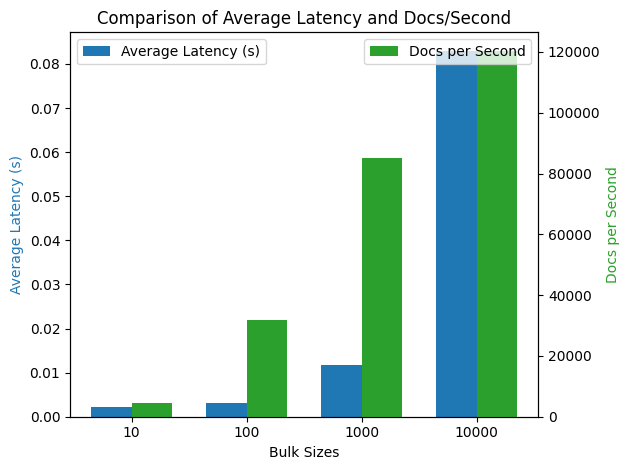

Range Query:


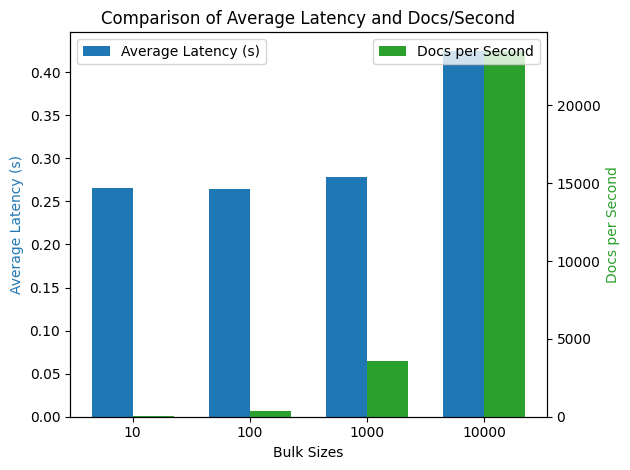

Mixed:


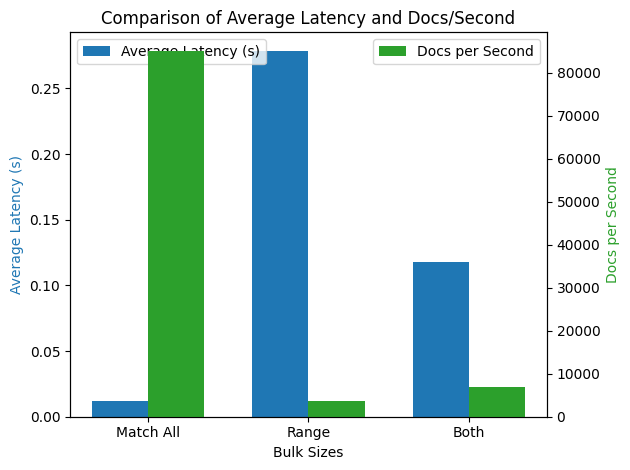

In [12]:
import numpy as np

def calculate_average_latency_and_docs_per_sec(benchmark_step):
    total_latency = 0
    total_docs = 0
    total_time = 0

    for query_result in benchmark_step.search_results:
        for load_gen_responses in query_result.responses:
            for response in load_gen_responses:
                if isinstance(response, SuccessResponse):
                    total_latency += response.latency
                    total_docs += response.docs
                    total_time += response.latency

    # Avoid division by zero
    if total_time == 0:
        return 0, 0

    average_latency = total_latency / sum(len(load_gen) for load_gen in query_result.responses)
    docs_per_second = total_docs / total_time if total_time > 0 else 0

    return average_latency, docs_per_second

def plot_grouped_bar_chart(benchmark_steps, labels):
    # Preparing data for plotting
    avg_latencies = []
    docs_per_sec = []

    for benchmark_step in benchmark_steps:
        avg_latency, doc_rate = calculate_average_latency_and_docs_per_sec(benchmark_step)
        avg_latencies.append(avg_latency)
        docs_per_sec.append(doc_rate)

    x = np.arange(len(labels))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax1 = plt.subplots()

    # Plotting average latency
    rects1 = ax1.bar(x - width/2, avg_latencies, width, label='Average Latency (s)', color='tab:blue')

    # Creating a second y-axis for throughput
    ax2 = ax1.twinx()
    rects2 = ax2.bar(x + width/2, docs_per_sec, width, label='Docs per Second', color='tab:green')

    # Adding labels, title, and legend
    ax1.set_xlabel('Bulk Sizes')
    ax1.set_ylabel('Average Latency (s)', color='tab:blue')
    ax2.set_ylabel('Docs per Second', color='tab:green')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Comparison of Average Latency and Docs/Second')

    fig.tight_layout()
    plt.show()

print("Match all:")
plot_grouped_bar_chart([MATCH_ALL_10, MATCH_ALL_100, MATCH_ALL_1000, MATCH_ALL_10000], 
                       ["10", "100", "1000", "10000"])
print("Range Query:")
plot_grouped_bar_chart([RANGE_10, RANGE_100, RANGE_1000, RANGE_10000], 
                       ["10", "100", "1000", "10000"])

print("Mixed:")
plot_grouped_bar_chart([MATCH_ALL_1000, RANGE_1000, RANGE_MATCH_ALL_MIXED], 
                       ["Match All", "Range", "Both"])

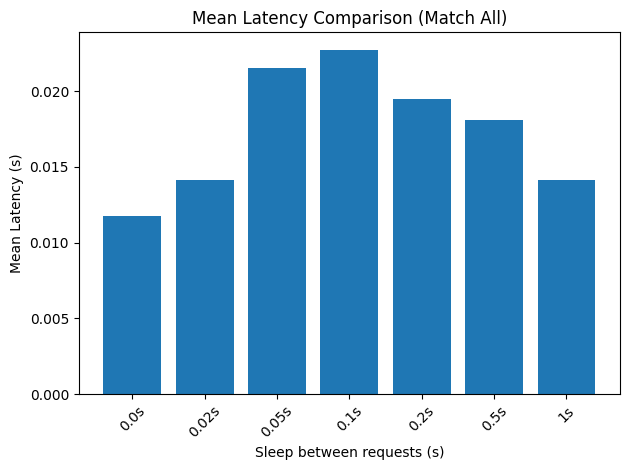

In [13]:
def plot_mean_latency_comparison(benchmark_steps, labels):
    mean_latencies = []

    for benchmark_step in benchmark_steps:
        total_latency = 0
        total_responses = 0

        for query_result in benchmark_step.search_results:
            for load_gen_responses in query_result.responses:
                for response in load_gen_responses:
                    if isinstance(response, SuccessResponse):
                        total_latency += response.latency
                        total_responses += 1

        mean_latency = total_latency / total_responses if total_responses > 0 else 0
        mean_latencies.append(mean_latency)

    # Plotting
    plt.bar(labels, mean_latencies)
    plt.xlabel('Sleep between requests (s)')
    plt.ylabel('Mean Latency (s)')
    plt.title('Mean Latency Comparison (Match All)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

benchmark_steps = [MATCH_ALL_1000, MATCH_ALL_SLEEP_0_02_SECS, MATCH_ALL_SLEEP_0_05_SECS, MATCH_ALL_SLEEP_0_1_SECS, MATCH_ALL_SLEEP_0_2_SECS, MATCH_ALL_SLEEP_0_5_SECS, MATCH_ALL_SLEEP_1_SEC]
labels = ["0.0s", "0.02s", "0.05s", "0.1s", "0.2s", "0.5s", "1s"]
plot_mean_latency_comparison(benchmark_steps, labels)